# Data Preprocessing

## Import the libraries

In [ ]:
!pip install ibm-cos-sdk 
import ibm_boto3
from ibm_botocore.client import Config
import pandas as pd
import numpy as np
import io, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.12.0-py3-none-any.whl size=73931 sha256=caeeb472b4fd1d9fea44dc714a285566e0a89cf88398929193ce8cd31f10fc75
  Stored in directory: /root/.cache/pip/wheels/ec/94/29/2b57327cf00664b6614304f7958abd29d77ea0e5bbece2ea57
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.12.0-py3-none-any.whl size=562962 sha256=3a0092eb6532ecfcd802f20b9ea4b746b62050badd7b4f1fce222cd84d5a4e8d
  Stored in directory: /root/.cache/pip/wheels/64/56/fb/5cd6f4f40406c828a5289b95b2752a4d142a9afb359244ed8d
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos_sdk_s3transfer-2.12.0-py3-none-any.whl size=89778 sha256=ef5bc221717ec0746d9576a995be48b2dde7d8c7719c124d9e1113651a931c00
  Stored in directory: /root/.cache/pip/wheels/57/79/6a/ffe3370ed7ebc00604f9f76766e1e0348dcdcad2b2e32df9e1
Successfully built ibm-cos-sdk ibm-cos-sdk-core ibm-cos-sdk-s3tr

## Importing the dataset

In [ ]:
cos_credentials={
  "apikey": "5lDfM8QcqpTFlKVVjKmm06zGbSspFR6gqGpmbFDWLlRc",
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297:resource-key:cd3a6762-cdaf-4808-b931-198e378e86d5",
  "iam_apikey_name": "pnt2022tmid13214",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/d2c796b84a794b58a1cff48368133ea1::serviceid:ServiceId-469be452-375b-4d58-9c23-d742c9a3256e",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/d2c796b84a794b58a1cff48368133ea1:e1e617d9-39a8-465d-bd9a-f3ca9bbb5297::"
}
auth_endpoint = 'https://iam.cloud.ibm.com/oidc/token'
service_endpoint = 'https://s3.us-east.cloud-object-storage.appdomain.cloud'
cos = ibm_boto3.client('s3',
                         ibm_api_key_id=cos_credentials['apikey'],
                        ibm_service_instance_id=cos_credentials['resource_instance_id'],
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)
obj =cos.get_object(Bucket='pnt2022tmid13214', Key='Crude Oil Prices Daily.xlsx')
df = pd.read_excel(io.BytesIO(obj['Body'].read()), header=None, names=['date', 'price'] ,skiprows=1)
df.head()

,date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


## Handling missing data

In [ ]:
df.isnull().any()

date     False
price     True
dtype: bool

In [ ]:
df.dropna(axis=0,inplace=True)
df.isnull().any()

date     False
price    False
dtype: bool

In [ ]:
df.shape

(8216, 2)

## Data visualization

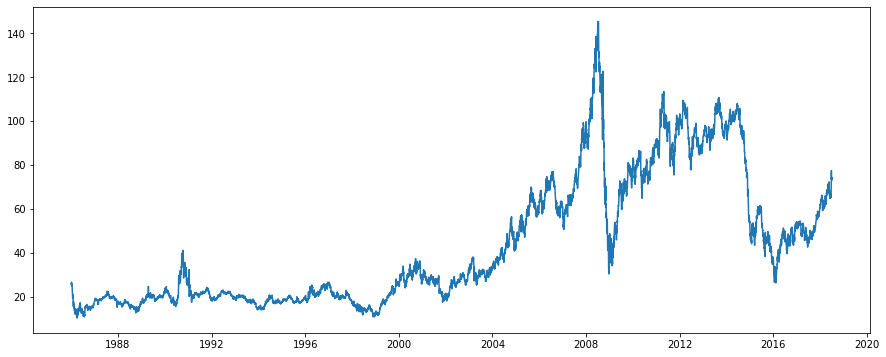

In [ ]:
plot = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df['date'])
price = list(df['price'])
data = pd.Series(price, time)
plt.plot(data)

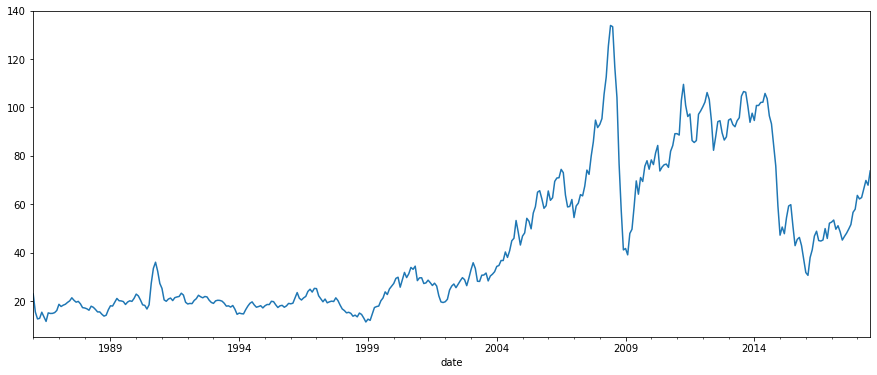

In [ ]:
#Decompose the plot
df.set_index('date', inplace=True)
y = df['price'].resample('MS').mean()
y.plot(figsize=(15, 6))
plt.show()

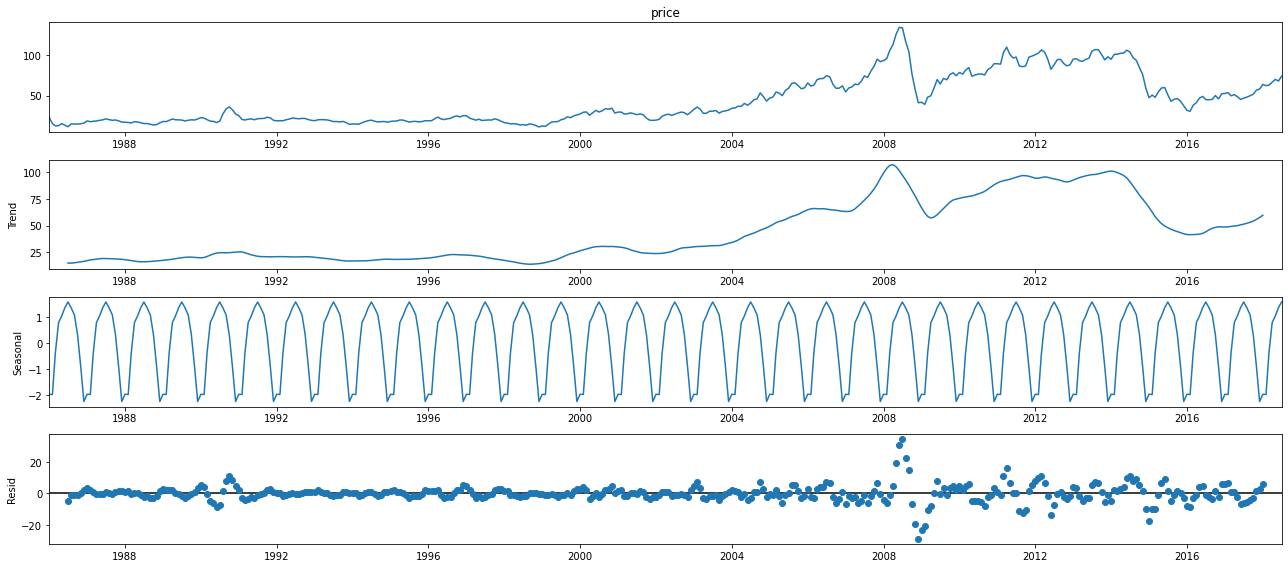

In [ ]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

## Feature Scaling


In [ ]:
df1 = df.reset_index()['price']
sc = MinMaxScaler(feature_range = (0, 1))
df1 = sc.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1.shape

(8216, 1)

## Train Test Split

In [ ]:
train_size = int(len(df1) * 0.80)
test_size = len(df1) - train_size
train, test = df1[0:train_size, :], df1[train_size:len(df1), :]

In [ ]:
len(test)

1644

## Creating Window

In [ ]:
def dataset(df, lookback=1):
    data_x, data_y = [], []
    for i in range(len(df) - lookback - 1):
        a = df[i:(i + lookback), 0]
        data_x.append(a)
        data_y.append(df[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

time_step = 10
# Reshape into X=t and Y=t+1
X_train , Y_train = dataset(train,time_step)
X_test , Y_test = dataset(test,time_step)
# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [ ]:
X_train.shape

(6561, 10, 1)